In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

# Print shape
X.shape, y.shape

((1000, 2), (1000,))

In [2]:
import pandas as pd
# Create Dataframe
df = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
df.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


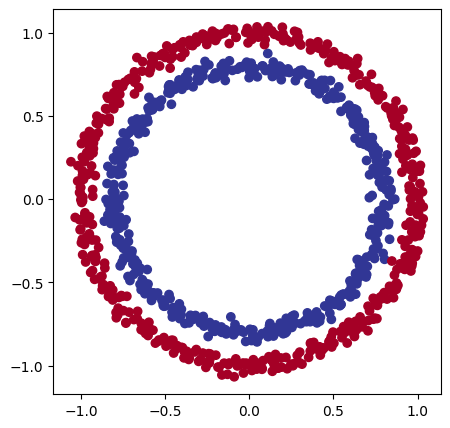

In [3]:
# Visualize df
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.scatter(df["X1"], df["X2"], c=df["label"], cmap=plt.cm.RdYlBu)
plt.show()

In [4]:
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

### **2/ Building Model**

In [5]:
import torch
import torch.nn as nn

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.relu = nn.ReLU() # For better learning
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)

    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        return self.layer_2(self.relu(self.layer_1(x)))

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (relu): ReLU()
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

The only major change is what's happening between self.layer_1 and self.layer_2.
That's self.layer_1 takes 2 input features in_features=2 and produces 5 output features out_features=5.

This is known as having 5 hidden units or neurons. This layer turns the input data from having 2 features to 5 features.

Why do this?

This allows the model to learn patterns from 5 numbers rather than just 2 numbers, potentially leading to better outputs. I say potentially because sometimes it doesn't work.

The number of hidden units you can use in neural network layers is a hyperparameter (a value you can set yourself) and there's no set in stone value you have to use.

Generally more is better but there's also such a thing as too much. The amount you choose will depend on your model type and dataset you're working with.

Since our dataset is small and simple, we'll keep it small.

The only rule with hidden units is that the next layer, in our case, self.layer_2 has to take the same in_features as the previous layer out_features.

That's why self.layer_2 has in_features=5, it takes the out_features=5 from self.layer_1 and performs a linear computation on them, turning them into out_features=1 (the same shape as y).

In [8]:
# Replicate CircleModelV0 with nn.Sequential
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=5),
#     nn.ReLU(),
#     nn.Linear(in_features=5, out_features=1),
#     nn.Sigmoid()
# ).to(device)

# model_0

In [9]:
# Make predictions with the model before training
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nTheir lable (by rounding):\n{torch.round(untrained_preds[:10])}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.3220],
        [0.2592],
        [0.4118],
        [0.2873],
        [0.2718],
        [0.2577],
        [0.1690],
        [0.1750],
        [0.4160],
        [0.2540]], device='cuda:0', grad_fn=<SliceBackward0>)

Their lable (by rounding):
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<RoundBackward0>)


### **3/ Set up Loss function and The Optimizer**



An evaluation metric can be used to offer another perspective on how your model is going. If a loss function measures how wrong your model is, I like to think of evaluation metrics as measuring how right it is.

Of course, you could argue both of these are doing the same thing but evaluation metrics offer a different perspective. After all, when evaluating your models it's good to look at things from multiple points of view.

In [17]:
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCELoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

def accuracy_function(y_true, y_pred):
    y_pred = y_pred.long()
    y_true = y_true.long()
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### **4/ Train Model**

In [22]:
model_0 = CircleModelV0().to(device)

In [23]:
device

'cuda'

In [24]:
# Set a random seed
torch.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put data into Tensors
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop
for epoch in range(epochs):
  ### Training
  model_0.train()
  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate Loss/Accuracy
  loss = criterion(y_logits, y_train)
  acc = accuracy_function(y_true=y_train,
                          y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate Loss/Accuracy
    test_loss = criterion(test_logits, y_test)
    test_acc = accuracy_function(y_true=y_test,
                                 y_pred=test_pred)

  ### Print information to follow training process through epochs
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.5f}")

Epoch: 0 | Loss: 0.69753, Accuracy: 50.00% | Test Loss: 0.69837, Test Accuracy: 50.00000
Epoch: 100 | Loss: 0.69753, Accuracy: 50.00% | Test Loss: 0.69837, Test Accuracy: 50.00000
Epoch: 200 | Loss: 0.69753, Accuracy: 50.00% | Test Loss: 0.69837, Test Accuracy: 50.00000
Epoch: 300 | Loss: 0.69753, Accuracy: 50.00% | Test Loss: 0.69837, Test Accuracy: 50.00000
Epoch: 400 | Loss: 0.69753, Accuracy: 50.00% | Test Loss: 0.69837, Test Accuracy: 50.00000
Epoch: 500 | Loss: 0.69753, Accuracy: 50.00% | Test Loss: 0.69837, Test Accuracy: 50.00000
Epoch: 600 | Loss: 0.69753, Accuracy: 50.00% | Test Loss: 0.69837, Test Accuracy: 50.00000
Epoch: 700 | Loss: 0.69753, Accuracy: 50.00% | Test Loss: 0.69837, Test Accuracy: 50.00000
Epoch: 800 | Loss: 0.69753, Accuracy: 50.00% | Test Loss: 0.69837, Test Accuracy: 50.00000
Epoch: 900 | Loss: 0.69753, Accuracy: 50.00% | Test Loss: 0.69837, Test Accuracy: 50.00000


In [49]:
import torch
import torch.nn as nn

# Kiểm tra thiết bị
device = "cuda" if torch.cuda.is_available() else "cpu"

# Xây dựng mô hình
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
        self.sigmoid = nn.Sigmoid()  # Thêm sigmoid để đảm bảo đầu ra là xác suất

    def forward(self, x):
        return self.sigmoid(self.layer_2(self.layer_1(x)))  # Áp dụng sigmoid

# Khởi tạo mô hình
model_1 = CircleModelV1().to(device)

# Chọn loss function và optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

# Hàm tính độ chính xác
def accuracy_function(y_true, y_pred):
    y_pred = y_pred.long()
    y_true = y_true.long()
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Thiết lập số epoch
torch.manual_seed(42)
epochs = 1000

# Đưa dữ liệu vào GPU nếu cần
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Vòng lặp huấn luyện
for epoch in range(epochs):
    ### Training
    model_1.train()
    y_pred = model_1(X_train).squeeze()  # Đầu ra đã sigmoid
    loss = criterion(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Tính accuracy trên tập huấn luyện
    acc = accuracy_function(y_train, torch.round(y_pred))

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test).squeeze()  # Đầu ra đã sigmoid
        test_loss = criterion(test_pred, y_test)

        # Tính accuracy trên tập test
        test_acc = accuracy_function(y_test, torch.round(test_pred))

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69569, Accuracy: 50.00% | Test Loss: 0.69739, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69405, Accuracy: 50.00% | Test Loss: 0.69622, Test Accuracy: 50.00%
Epoch: 200 | Loss: 0.69344, Accuracy: 45.88% | Test Loss: 0.69587, Test Accuracy: 47.00%
Epoch: 300 | Loss: 0.69322, Accuracy: 49.12% | Test Loss: 0.69577, Test Accuracy: 47.00%
Epoch: 400 | Loss: 0.69312, Accuracy: 49.00% | Test Loss: 0.69573, Test Accuracy: 47.00%
Epoch: 500 | Loss: 0.69308, Accuracy: 50.12% | Test Loss: 0.69569, Test Accuracy: 46.50%
Epoch: 600 | Loss: 0.69306, Accuracy: 50.25% | Test Loss: 0.69564, Test Accuracy: 46.00%
Epoch: 700 | Loss: 0.69305, Accuracy: 50.25% | Test Loss: 0.69559, Test Accuracy: 46.00%
Epoch: 800 | Loss: 0.69304, Accuracy: 50.75% | Test Loss: 0.69554, Test Accuracy: 46.50%
Epoch: 900 | Loss: 0.69303, Accuracy: 50.50% | Test Loss: 0.69548, Test Accuracy: 46.50%


In [37]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Chuyển model và dữ liệu về CPU để làm việc với NumPy + Matplotlib
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Thiết lập lưới điểm để vẽ boundary
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Chuẩn bị dữ liệu đầu vào cho model
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Dự đoána
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Kiểm tra bài toán binary hay multi-class
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # Multi-class
    else:
        y_pred = torch.round(y_logits)  # Binary (đã có Sigmoid trong model)

    # Reshape kết quả để vẽ
    y_pred = y_pred.reshape(xx.shape).detach().numpy()

    # Vẽ decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y.numpy(), s=40, cmap=plt.cm.RdYlBu, edgecolors="k")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundary")
    plt.show()


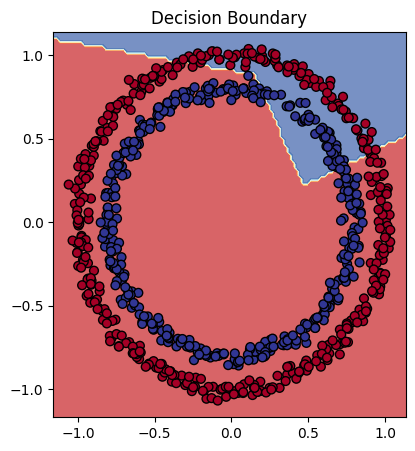

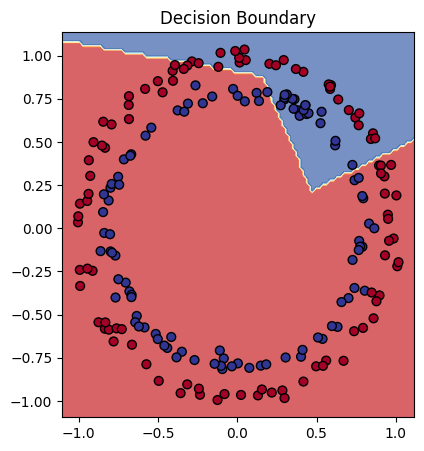

In [48]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

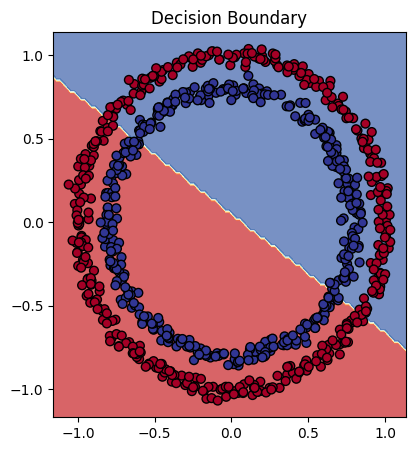

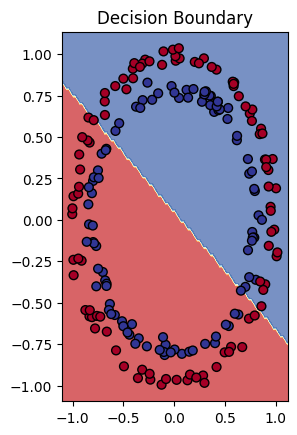

In [50]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

Oh wow, it seems like we've found the cause of model's performance issue.

It's currently trying to split the red and blue dots using a straight line...

That explains the 50% accuracy. Since our data is circular, drawing a straight line can at best cut it down the middle.

In machine learning terms, our model is underfitting, meaning it's not learning predictive patterns from the data.


### **5/ Improve Model**

In [60]:
import torch
import torch.nn as nn

# Kiểm tra thiết bị
device = "cuda" if torch.cuda.is_available() else "cpu"

# Xây dựng mô hình
model_3 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.ReLU(),
    nn.Linear(in_features=5, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=1)  # Không cần Sigmoid ở đây vì dùng BCEWithLogitsLoss
).to(device)

# Chọn loss function và optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.01)

# Hàm tính độ chính xác
def accuracy_function(y_true, y_pred):
    y_pred = y_pred.long()  # Chuyển y_pred về kiểu int để so sánh
    y_true = y_true.long()
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Thiết lập số epoch
torch.manual_seed(42)
epochs = 1000

# Đưa dữ liệu vào GPU và chuyển sang kiểu float
X_train, y_train = X_train.to(device), y_train.to(device).float()
X_test, y_test = X_test.to(device), y_test.to(device).float()

# Vòng lặp huấn luyện
for epoch in range(epochs):
    model_3.train()
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))  # Chuyển logits thành xác suất rồi làm tròn thành nhãn (0 hoặc 1)

    loss = loss_fn(y_logits, y_train)  # BCEWithLogitsLoss sử dụng logits trực tiếp
    acc = accuracy_function(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))  # Chuyển logits thành nhãn dự đoán
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_function(y_test, test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69731, Accuracy: 50.00% | Test Loss: 0.69438, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.13775, Accuracy: 99.62% | Test Loss: 0.17049, Test Accuracy: 98.50%
Epoch: 200 | Loss: 0.01892, Accuracy: 100.00% | Test Loss: 0.04282, Test Accuracy: 99.50%
Epoch: 300 | Loss: 0.00808, Accuracy: 100.00% | Test Loss: 0.02423, Test Accuracy: 100.00%
Epoch: 400 | Loss: 0.00470, Accuracy: 100.00% | Test Loss: 0.01763, Test Accuracy: 100.00%
Epoch: 500 | Loss: 0.00313, Accuracy: 100.00% | Test Loss: 0.01395, Test Accuracy: 100.00%
Epoch: 600 | Loss: 0.00226, Accuracy: 100.00% | Test Loss: 0.01153, Test Accuracy: 100.00%
Epoch: 700 | Loss: 0.00171, Accuracy: 100.00% | Test Loss: 0.00983, Test Accuracy: 100.00%
Epoch: 800 | Loss: 0.00135, Accuracy: 100.00% | Test Loss: 0.00857, Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.00109, Accuracy: 100.00% | Test Loss: 0.00766, Test Accuracy: 100.00%


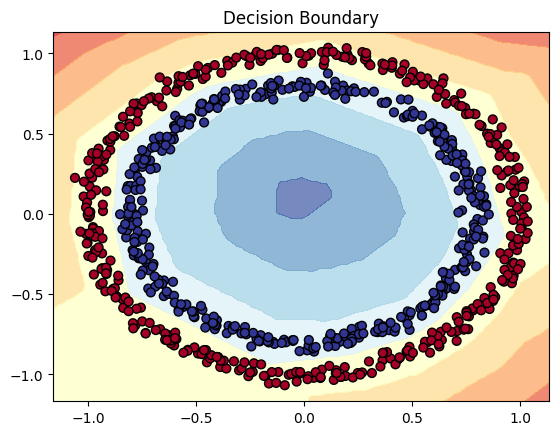

In [61]:
plot_decision_boundary(model_3, X_train, y_train)

### **6/ More Labels**

In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [90]:
try:
  from torchmetrics import Accuracy
except:
  !pip install torchmetrics
  from torchmetrics import Accuracy

In [91]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    # The original code only used the first 2 features.
    # This line is changed to use all 12 features by padding with zeros for the remaining 10 features.
    num_features = X.shape[1]
    grid_data = np.c_[xx.ravel(), yy.ravel()]
    grid_data = np.pad(grid_data, ((0, 0), (0, num_features - 2)), 'constant', constant_values=0)  # Pad with zeros
    X_to_pred_on = torch.from_numpy(grid_data).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

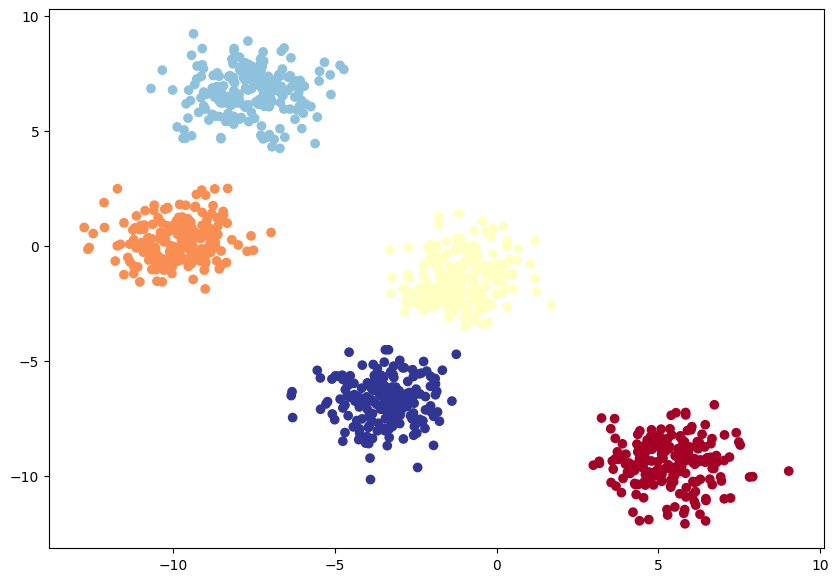

In [92]:
# Prepare dataset
NUM_CLASSES = 5
NUM_FEATURES = 12
RANDOM_SEED = 10
NUM_SAMPLES = 1000

X, y = make_blobs(n_samples=NUM_SAMPLES,
                  n_features=NUM_FEATURES,
                  centers=NUM_CLASSES,
                  random_state=RANDOM_SEED)

# Turn data into Tensors
X, y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.long)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

In [101]:
# Build Model to classify these samples
class BlobsModel(nn.Module):
  def __init__(self, input_features, output_features):
    super().__init__()
    self.layer1 = nn.Linear(in_features=input_features, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=15)
    self.layer3 = nn.Linear(in_features=15, out_features=output_features)
    self.relu = nn.ReLU()

  def forward(self, x):
    # return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
    return self.layer3(self.layer2(self.layer1(x))) # No need activation


In [102]:
blobs_model = BlobsModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES)
# Put model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
blobs_model.to(device)

cpu


BlobsModel(
  (layer1): Linear(in_features=12, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=15, bias=True)
  (layer3): Linear(in_features=15, out_features=5, bias=True)
  (relu): ReLU()
)

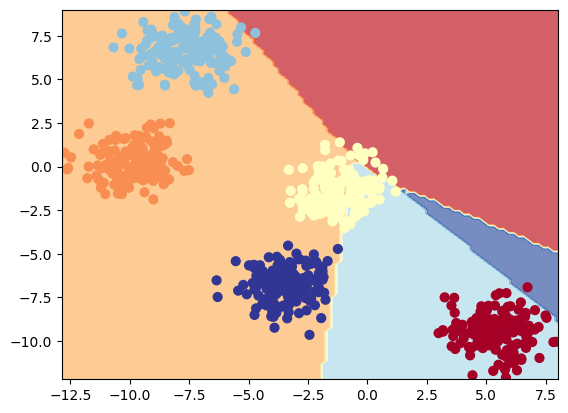

In [103]:
# Before Training
plot_decision_boundary(blobs_model, X_train, y_train)

In [104]:
# Create criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(blobs_model.parameters(), lr=0.01)

In [105]:
# TRANING PHASE

# Set random state
torch.manual_seed(RANDOM_SEED)

# Put data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Initialize num epochs
epochs = 100

# Setup metric and make sure it's on the target device
accuracy = Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(device)

for epoch in range(epochs):
  ### Training
  blobs_model.train()

  # 1. Forward pass
  y_logits = blobs_model(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # logits -> probabilities -> labels

  # 2. Calculate the loss
  loss = criterion(y_logits, y_train)
  acc = accuracy(y_train, y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  blobs_model.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = blobs_model(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1) # logits -> probabilities -> labels

    # 2. Calculate the loss
    test_loss = criterion(test_logits, y_test)
    test_acc = accuracy(y_test, test_pred)

  ### Tracking process by printing information through epochs
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 2.54171, Accuracy: 0.00% | Test Loss: 1.92393, Test Accuracy: 0.22%
Epoch: 10 | Loss: 0.06248, Accuracy: 1.00% | Test Loss: 0.04281, Test Accuracy: 1.00%
Epoch: 20 | Loss: 0.00235, Accuracy: 1.00% | Test Loss: 0.00177, Test Accuracy: 1.00%
Epoch: 30 | Loss: 0.00031, Accuracy: 1.00% | Test Loss: 0.00026, Test Accuracy: 1.00%
Epoch: 40 | Loss: 0.00011, Accuracy: 1.00% | Test Loss: 0.00010, Test Accuracy: 1.00%
Epoch: 50 | Loss: 0.00007, Accuracy: 1.00% | Test Loss: 0.00007, Test Accuracy: 1.00%
Epoch: 60 | Loss: 0.00006, Accuracy: 1.00% | Test Loss: 0.00005, Test Accuracy: 1.00%
Epoch: 70 | Loss: 0.00005, Accuracy: 1.00% | Test Loss: 0.00005, Test Accuracy: 1.00%
Epoch: 80 | Loss: 0.00005, Accuracy: 1.00% | Test Loss: 0.00005, Test Accuracy: 1.00%
Epoch: 90 | Loss: 0.00004, Accuracy: 1.00% | Test Loss: 0.00004, Test Accuracy: 1.00%


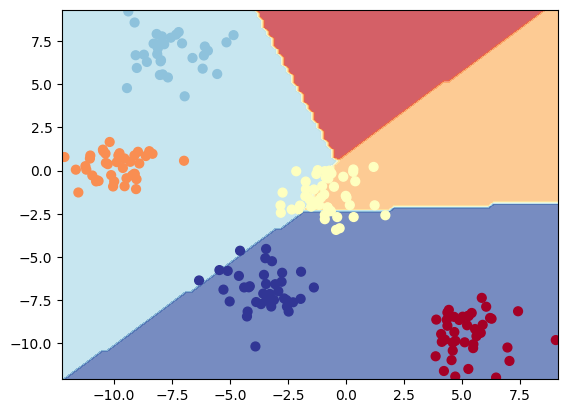

In [106]:
plot_decision_boundary(blobs_model, X_test, y_test)

### **Bonus: Exercise**

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

try:
  from torchmetrics import Accuracy
except:
  !pip install torchmetrics -q
  from torchmetrics import Accuracy


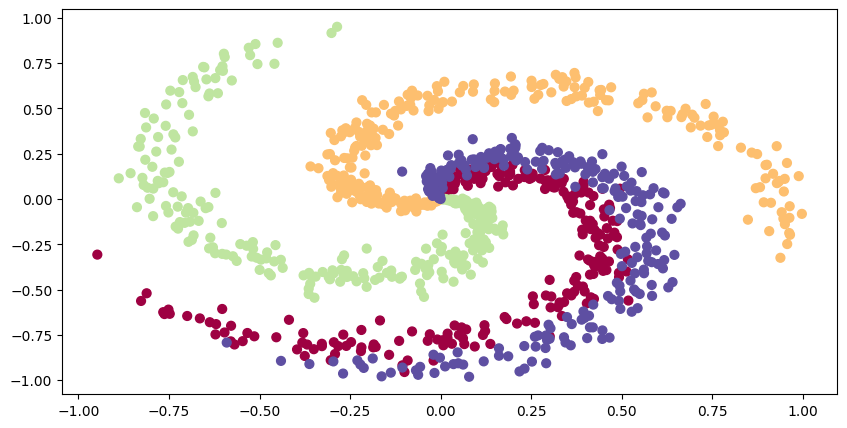

In [112]:
import numpy as np

def make_spirals(n_samples, n_features, n_classes, random_state=10):
  N = int(n_samples/n_classes) # number of points per class
  X = np.zeros((N*n_classes,n_features)) # data matrix (each row = single example)
  y = np.zeros(N*n_classes, dtype='uint8') # class labels
  for j in range(n_classes):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
  return X, y

# lets visualize the data
X, y = make_spirals(n_samples=1000, n_features=2, n_classes=4)
plt.figure(figsize=(10,5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [113]:
# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [123]:
### Data preparation

# Put data into Tensors
X = torch.from_numpy(X).type(torch.float).to(device) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor).to(device) # labels need to be of type long

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

TypeError: expected np.ndarray (got Tensor)

In [189]:
### Build model
spiral_model = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=25),
    nn.Softplus(),
    nn.Linear(in_features=25, out_features=15),
    nn.Tanh(),
    nn.Linear(in_features=15, out_features=4)

)

spiral_model.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=25, bias=True)
  (3): Softplus(beta=1.0, threshold=20.0)
  (4): Linear(in_features=25, out_features=15, bias=True)
  (5): Tanh()
  (6): Linear(in_features=15, out_features=4, bias=True)
)

In [190]:
### Create criterion, optimizer, metrics...
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(spiral_model.parameters(), lr=0.01)
accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

In [191]:
### Training loop for model
torch.manual_seed(42)
epochs = 100

for epoch in range(epochs):
  ### Training phase
  spiral_model.train()

  y_logits = spiral_model(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
  loss = criterion(y_logits, y_train)
  acc = accuracy(y_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Eval phase
  spiral_model.eval()
  with torch.inference_mode():
    test_logits = spiral_model(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = criterion(test_logits, y_test)
    test_acc = accuracy(y_test, test_pred)

  ### Tracking training process
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.39323, Accuracy: 0.24% | Test Loss: 1.39496, Test Accuracy: 0.22%
Epoch: 10 | Loss: 1.34245, Accuracy: 0.34% | Test Loss: 1.34384, Test Accuracy: 0.41%
Epoch: 20 | Loss: 1.21205, Accuracy: 0.35% | Test Loss: 1.21817, Test Accuracy: 0.32%
Epoch: 30 | Loss: 1.09408, Accuracy: 0.46% | Test Loss: 1.11811, Test Accuracy: 0.38%
Epoch: 40 | Loss: 0.96580, Accuracy: 0.60% | Test Loss: 1.03628, Test Accuracy: 0.51%
Epoch: 50 | Loss: 0.88065, Accuracy: 0.65% | Test Loss: 0.96472, Test Accuracy: 0.56%
Epoch: 60 | Loss: 0.78696, Accuracy: 0.68% | Test Loss: 0.85201, Test Accuracy: 0.60%
Epoch: 70 | Loss: 0.68051, Accuracy: 0.73% | Test Loss: 0.72485, Test Accuracy: 0.70%
Epoch: 80 | Loss: 0.57321, Accuracy: 0.76% | Test Loss: 0.59887, Test Accuracy: 0.75%
Epoch: 90 | Loss: 0.46945, Accuracy: 0.82% | Test Loss: 0.48181, Test Accuracy: 0.81%


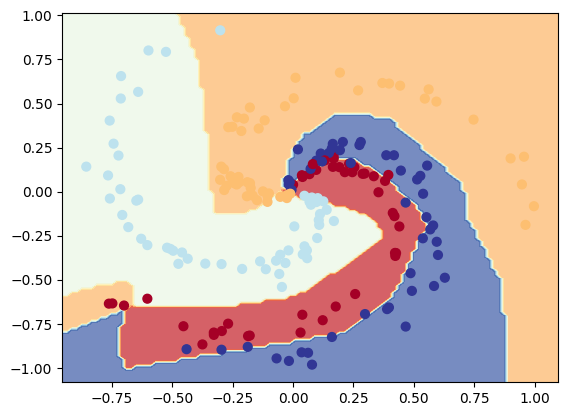

In [192]:
# Plot to see result
plot_decision_boundary(spiral_model, X_test, y_test)